In [1]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import repeat
from pandas.errors import SettingWithCopyWarning
import warnings
from sklearn.model_selection import TimeSeriesSplit

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Fast Arima
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA,
                                  SeasonalExponentialSmoothing)

C:\Users\SARK\anaconda3\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Suppress copy warning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
cols = [
    "time",
    "temp",
    "clouds",
    "humidity",
    "system_demand"
]

df = pd.read_csv("caiso_data_8_Aug.csv", parse_dates=["time"], usecols=cols)

In [4]:
df.isna().sum()

time             0
system_demand    8
temp             3
clouds           0
humidity         7
dtype: int64

In [5]:
# Check if traget has leading nans
df[df.system_demand.isna()].head()

,time,system_demand,temp,clouds,humidity
0,2023-02-01 00:00:00,NaN,49.05,0,47.0
1,2023-02-01 01:00:00,NaN,48.83,0,43.0
2,2023-02-01 02:00:00,NaN,48.85,0,44.0
3,2023-02-01 03:00:00,NaN,48.07,0,41.0
65,2023-02-03 17:00:00,NaN,63.50,0,44.0


In [6]:
def fill_gaps(df, col_name, fill_method):
    
    # Drop by targets. If target has nans at the beginning
    valid_start = df[col_name].first_valid_index()
    df_new = df.loc[valid_start:, :].reset_index(drop=True)

    if fill_method=="bfill":
        df_new[col_name] = df_new[col_name].fillna(method="bfill")

    if fill_method=="ffill":
        df_new[col_name] = df_new[col_name].fillna(method="ffill")

    if fill_method=="interpolate":
        df_new[col_name] = df_new[col_name].interpolate(limit_area="inside") # Won't use ffill

    if fill_method=="weekly_pattern":
        grain = pd.infer_freq(df_new.set_index("time").index)

        if grain=="H":
            # Get the nans as df
            nans_df =  df_new[df_new[col_name].isna()]

            # Store the weekly values
            replace_by = []
            for idx in nans_df.index:
                try:
                    replace_by.append(df_new.loc[idx+168, col_name])
                except:
                    replace_by.append(df_new.loc[idx-168, col_name])

            # Replace the nans with the values in replace by
            df_new.loc[nans_df.index, col_name] = replace_by
            return df_new

    return df_new

In [7]:
# Drop leading nans from traget and use weekly pattern
df = fill_gaps(df, "system_demand", "weekly_pattern")

# Use weekly pattern to fill gaps
df = fill_gaps(df, "temp", "weekly_pattern")
df = fill_gaps(df, "humidity", "weekly_pattern")

In [8]:
df.isna().sum()

time             0
system_demand    0
temp             0
clouds           0
humidity         0
dtype: int64

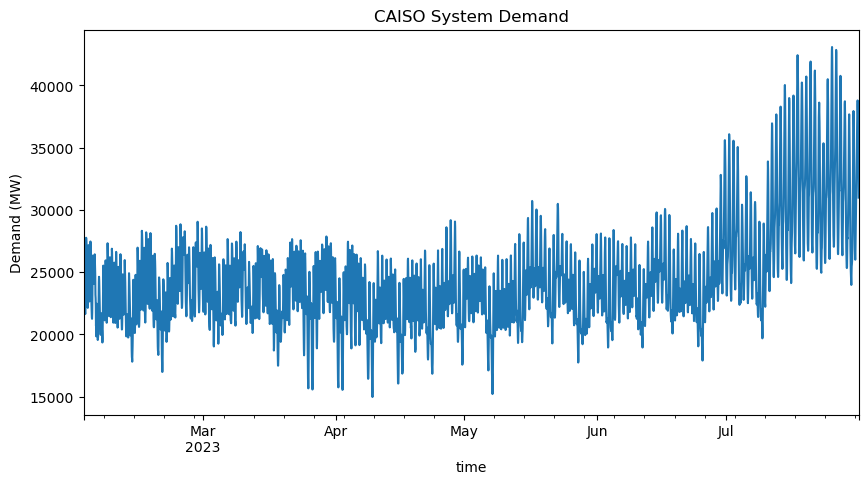

In [9]:
# Plot target
df.set_index("time").system_demand.plot(figsize=(10, 5), title="CAISO System Demand", ylabel="Demand (MW)")
plt.show()

In [10]:
df = df.set_index("time")

In [11]:
# Create a function for ts split
def get_ts_splits(df, n_splits, target, test_size):
    temp_df = df.copy(deep=True)
    
    X = temp_df.drop([target], axis=1)
    y = temp_df[target]

    tss = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

    xtrain = []
    ytrain = []
    xtest = []
    ytest = []
    folds = []

    fold = 0
    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index].to_frame(), y.iloc[test_index].to_frame()
        fold +=1
        X_train["fold"] = fold
        y_train["fold"] = fold
        X_test["fold"] = fold
        y_test["fold"] = fold
        xtrain.append(X_train)
        ytrain.append(y_train)
        xtest.append(X_test)
        ytest.append(y_test)
        print(f"Fold: {fold}")
        print(f"Train starts: {X_train[X_train.fold==fold].head(1).index[0]}, ends: {X_train[X_train.fold==fold].tail(1).index[0]}, size: {X_train[X_train.fold==fold].shape[0]}")
        print(f"Test starts: {X_test[X_test.fold==fold].head(1).index[0]}, ends: {X_test[X_test.fold==fold].tail(1).index[0]}, size: {X_test[X_test.fold==fold].shape[0]}")
        print("\n")
    
    train_x = pd.concat(xtrain)
    train_y = pd.concat(ytrain)
    test_x = pd.concat(xtest)
    test_y = pd.concat(ytest)
    return train_x, train_y, test_x, test_y

In [12]:
# We want to forecast 5 days into the future
train_x, train_y, test_x, test_y = get_ts_splits(df, 10, "system_demand", 24*5)

Fold: 1
Train starts: 2023-02-01 04:00:00, ends: 2023-06-11 23:00:00, size: 3140
Test starts: 2023-06-12 00:00:00, ends: 2023-06-16 23:00:00, size: 120


Fold: 2
Train starts: 2023-02-01 04:00:00, ends: 2023-06-16 23:00:00, size: 3260
Test starts: 2023-06-17 00:00:00, ends: 2023-06-21 23:00:00, size: 120


Fold: 3
Train starts: 2023-02-01 04:00:00, ends: 2023-06-21 23:00:00, size: 3380
Test starts: 2023-06-22 00:00:00, ends: 2023-06-26 23:00:00, size: 120


Fold: 4
Train starts: 2023-02-01 04:00:00, ends: 2023-06-26 23:00:00, size: 3500
Test starts: 2023-06-27 00:00:00, ends: 2023-07-01 23:00:00, size: 120


Fold: 5
Train starts: 2023-02-01 04:00:00, ends: 2023-07-01 23:00:00, size: 3620
Test starts: 2023-07-02 00:00:00, ends: 2023-07-06 23:00:00, size: 120


Fold: 6
Train starts: 2023-02-01 04:00:00, ends: 2023-07-06 23:00:00, size: 3740
Test starts: 2023-07-07 00:00:00, ends: 2023-07-11 23:00:00, size: 120


Fold: 7
Train starts: 2023-02-01 04:00:00, ends: 2023-07-11 23:00:00, size: 

In [13]:
def create_train_test_data(fold):
    train = pd.concat([train_x[train_x.fold==fold], train_y[train_y.fold==fold]], axis=1).drop("fold", axis=1)
    test = test_x[test_x.fold==fold].drop("fold", axis=1)
    m = pd.concat([train, test])
    m["fold"] = fold
    return m, test_y[test_y.fold==fold]

def make_ts_split_forecast(fold):
    final_df, test_y = create_train_test_data(fold)
    return final_df, test_y

In [14]:
class Forecast:
    """
    ref_df = main dataframe (fina_df),
    train_start = training start date
    train_end = training end date
    forecast_horizon = number of periods to forecast into the future
    """
    def __init__(self, ref_df, train_start, train_end, forecast_horizon):
        self.ref_df=ref_df
        self.grain=pd.infer_freq(ref_df.set_index("time").index) # Find the grain of the data
        self.train_start=train_start
        self.train_end=train_end
        self.forecast_horizon=forecast_horizon
        
        # Create train df with time only
        self.train_df = pd.DataFrame({
            "time":pd.date_range(start=train_start, end=self.train_end, freq=self.grain)
        })
        
        # Create forecast df with time only
        self.forecast_df = pd.DataFrame({
            "time":pd.date_range(start=pd.to_datetime(self.train_end)+pd.Timedelta(value=1, unit=self.grain),
                                 periods=forecast_horizon, freq=self.grain)
        })
        
        # Merge train and forecast df
        self.merged_df = pd.concat([self.train_df, self.forecast_df]).reset_index(drop=True)
    
    # Add the target to the dataframe
    def add_target(self, target):
        self.target=target
        return pd.merge(self.merged_df, self.ref_df[[target, "time"]], on="time", how="left")
    
    # Add features to the dataframe
    def add_features(self, df, features):
        return pd.merge(df, self.ref_df.set_index("time")[features].reset_index(), on="time", how="left")
    
    # Apply gap filling method on a feature or target
    def fill_gap(self, df, col_name, method):
        if method=="forward_fill":
            df[col_name] = df[col_name].fillna(method="ffill")
            return df
        
        if method=="backward_fill":
            df[col_name] = df[col_name].fillna(method="bfill")
            return df
        
        if method=="linear_interpolation":
            df[col_name] = df[col_name].interpolate(limit_area="inside") # Won't use ffill
            return df
    
    # Add builtins (time related features) into the dataframe
    def add_builtins(self, df, builtin):
        if builtin=="hour":
            df["hour"] = df.time.dt.hour
            
        if builtin=="month":
            df["month"] = df.time.dt.month
            
        if builtin=="day":
            df["day"] = df.time.dt.day_of_week
        return df
    
    # Add lagged predictor into the dataframe
    def add_lags(self, df, col_name, lag_size):
        self.lag_size=lag_size
        with_lag = df
        with_lag[col_name] = with_lag[self.target].shift(lag_size)
        return with_lag
    
    # Add rolling avg as a predictor
    def add_rolling_avg(self, df, col_name, rolling_avg_size):
        self.rolling_avg_size=rolling_avg_size
        with_sma = df
        with_sma[col_name] = with_sma[self.target].rolling(rolling_avg_size).mean().shift()
        return with_sma
    
    # Add rolling std as a predictor
    def add_rolling_std(self, df, col_name, rolling_std_size):
        self.rolling_std_size=rolling_std_size
        with_smstd = df
        with_smstd[col_name] = with_smstd[self.target].rolling(rolling_std_size).std().shift()
        return with_smstd
    
    # Get the trained model (ml or statistical)
    def get_trained_model(self, df, model_type, model):
        self.model=model
        self.model_type=model_type
        
        train_df = df[df.time.between(self.train_start, self.train_end)].dropna().set_index("time")
        forecast_df = df[df.time>=self.forecast_df.time.iloc[0]].drop(self.target, axis=1).set_index("time")
        
        if model_type=="ml":
            model.fit(train_df.iloc[:, 1:].query("index<=@self.train_end"),
                  train_df.loc[:, self.target].to_frame().query("index<=@self.train_end"))
            return model, pd.concat([train_df, forecast_df])
        
        if model_type=="statistical":
            train_df = train_df.reset_index()
            train_df.insert(loc=0, column="unique_id", value="x")
            train_df = train_df.rename(columns={self.target:"y", "time":"ds"})

            forecast_df = forecast_df.reset_index()
            forecast_df.insert(loc=0, column="unique_id", value="y")
            forecast_df = forecast_df.rename(columns={"time":"ds"})
            sf = StatsForecast(models = [model],
                               freq = self.grain,
                               n_jobs=-1,
                               df=train_df)
            sf.fit(train_df)
            return sf, forecast_df
    
    # Make forecast using the trained model (ml or ststistical)
    def make_forecast(self, forecast_date, trained_model, df):
        if self.model_type=="ml":
            if "pp" in df.columns:
                pp_over = pd.to_datetime(forecast_date)-pd.Timedelta(self.lag_size, self.grain)
                df.at[forecast_date, "pp"] = df[df.index==pp_over][self.target]

            if "rolling_avg" in df.columns:
                sma_over = pd.to_datetime(forecast_date)-pd.Timedelta(self.rolling_avg_size, self.grain)
                df.at[forecast_date, "rolling_avg"] = df[df.index>=sma_over].head(self.rolling_avg_size)[self.target].mean()

            if "rolling_std" in df.columns:
                smstd_over = pd.to_datetime(forecast_date)-pd.Timedelta(self.rolling_std_size, self.grain)
                df.at[forecast_date, "rolling_std"] = df[df.index>=smstd_over].head(self.rolling_std_size)[self.target].std()

            pred = trained_model.predict(df.query("index==@forecast_date").iloc[:, 1:])
            df.at[forecast_date, self.target] = pred
            return df
        
        if self.model_type=="statistical":
            pred = trained_model.predict(h=self.forecast_horizon, X_df=df).reset_index(drop=True).iloc[:, -1].to_frame()
            pred.columns = ["forecast"]
            return pred

#### 1. XGBoost

In [15]:
def final_forecast(fold, target, model_type, model):
    final_df, test_y = make_ts_split_forecast(fold)
    train_start = final_df.index[0]
    train_end = final_df[final_df[target].notna()].index[-1]
    forecast_horizon = final_df[final_df[target].isna()].shape[0]
    
    final_df = final_df.reset_index()
    
    f = Forecast(
     ref_df=final_df,
     train_start=train_start,
     train_end=train_end,
     forecast_horizon=forecast_horizon)
    
    df = f.add_target(target)
#     df = f.fill_gap(df, target, "linear_interpolation")
    
    df = f.add_features(df, "temp")
    
    df = f.add_builtins(df, "hour")
    df = f.add_builtins(df, "month")
    
    df = f.add_lags(df, "pp", 1)
    
    df = f.add_rolling_avg(df, "rolling_avg", 4)
#     df = f.add_rolling_std(df, "rolling_std", 4)
    
    m, df = f.get_trained_model(df, model_type="ml", model=model)
    
    dates = df[df[target].isna()].index
    df = pd.concat(list(map(f.make_forecast, dates, repeat(m), repeat(df))))
    df = df[~df.index.duplicated(keep="first")] # Very important, drops duplicates by index
    y_test = test_y[target]
    y_pred = df.tail(test_y.shape[0])[target]
    pred_df = pd.DataFrame({
        "Actual":y_test,
        "Pred":y_pred
    })
    mape = mean_absolute_percentage_error(pred_df.Actual, pred_df.Pred)
    print(f"MAPE for fold {fold}: {mape}")
    return mape

In [16]:
mape = []
for i in range(1, 11):
    m = final_forecast(i, "system_demand", "ml", XGBRegressor(random_state=43))
    mape.append(m)
print(f"Avg mape for XGB:{np.mean(mape)}")

MAPE for fold 1: 0.14904123993946192
MAPE for fold 2: 0.05780615662518618
MAPE for fold 3: 0.08609762560978966
MAPE for fold 4: 0.07438184537951678
MAPE for fold 5: 0.07424710613112889
MAPE for fold 6: 0.10872030147066945
MAPE for fold 7: 0.06283149384679189
MAPE for fold 8: 0.058324877806111015
MAPE for fold 9: 0.028949369926516203
MAPE for fold 10: 0.058767695315391014
Avg mape for XGB:0.0759167712050563


#### 2. CatBoost

In [17]:
mape = []
for i in range(1, 11):
    m = final_forecast(i, "system_demand", "ml", CatBoostRegressor(logging_level="Silent"))
    mape.append(m)
print(f"Avg mape for CatBoost:{np.mean(mape)}")

MAPE for fold 1: 0.10828296233774058
MAPE for fold 2: 0.08119858819090657
MAPE for fold 3: 0.07459033500020075
MAPE for fold 4: 0.07193192222582583
MAPE for fold 5: 0.05984613234932888
MAPE for fold 6: 0.07768113410965322
MAPE for fold 7: 0.05875481227424831
MAPE for fold 8: 0.06697128147008566
MAPE for fold 9: 0.03465472499147505
MAPE for fold 10: 0.045570146674002505
Avg mape for CatBoost:0.06794820396234674


#### 3. LGBM

In [18]:
mape = []
for i in range(1, 11):
    m = final_forecast(i, "system_demand", "ml", LGBMRegressor(random_state=43))
    mape.append(m)
print(f"Avg mape for LGBM:{np.mean(mape)}")

MAPE for fold 1: 0.07845480044447983
MAPE for fold 2: 0.037163708437095724
MAPE for fold 3: 0.07094936610117436
MAPE for fold 4: 0.08198665927057788
MAPE for fold 5: 0.202772810988879
MAPE for fold 6: 0.09744335513423437
MAPE for fold 7: 0.12308305199669702
MAPE for fold 8: 0.07909074841253162
MAPE for fold 9: 0.04010964976412546
MAPE for fold 10: 0.055143841426817816
Avg mape for LGBM:0.08661979919766132


#### Retrain with Catboost
Temp and humidity are available 2 days into the future. So we will only have temp and humidity for 2 days and the remaining 3 days have to be imputed. Let's read the test data. Please look at the test data to understand the data better

In [19]:
df_test = pd.read_csv("test_data.csv", parse_dates=["time"])

In [20]:
df_test.isna().sum()

time              0
system_demand     8
temp             75
clouds           72
humidity         76
dtype: int64

In [21]:
# Drop leading nans from traget and use weekly pattern
df_test = fill_gaps(df_test, "system_demand", "weekly_pattern")

# Use weekly pattern to fill gaps
df_test = fill_gaps(df_test, "temp", "weekly_pattern")
df_test = fill_gaps(df_test, "humidity", "weekly_pattern")

In [22]:
df_test.isna().sum()

time              0
system_demand     0
temp              0
clouds           72
humidity          0
dtype: int64

In [23]:
# Make forecast
f = Forecast(
    ref_df=df_test,
    train_start=df_test.time.iloc[0],
    train_end=df_test.time.iloc[-121], # Ending 5 days before
    forecast_horizon=5*24 # Forecasting 5 days
)

df_test = f.add_target("system_demand")
df_test = f.add_features(df_test, "temp")
df_test = f.add_builtins(df_test, "hour")
df_test = f.add_builtins(df_test, "month")
df_test = f.add_lags(df_test, "pp", 1)
df_test = f.add_rolling_avg(df_test, "rolling_avg", 4)
m, df_test = f.get_trained_model(df_test, model_type="ml", model=CatBoostRegressor(logging_level="Silent"))
    
dates = df_test[df_test["system_demand"].isna()].index
df_test = pd.concat(list(map(f.make_forecast, dates, repeat(m), repeat(df_test))))
df_test = df_test[~df_test.index.duplicated(keep="first")] # Very important, drops duplicates by index

In [24]:
# Calculate mape for last 5 days
y_pred = df_test.iloc[-120:][["system_demand"]].rename(columns={"system_demand":"Prediction"})
y_test = pd.read_csv("test_data.csv", parse_dates=["time"]).iloc[-120:].set_index("time")[["system_demand"]].rename(columns={"system_demand":"Actual"})
mape = mean_absolute_percentage_error(y_test, y_pred)
y_test["Prediction"] = y_pred.squeeze()
mape

0.04108634125803478

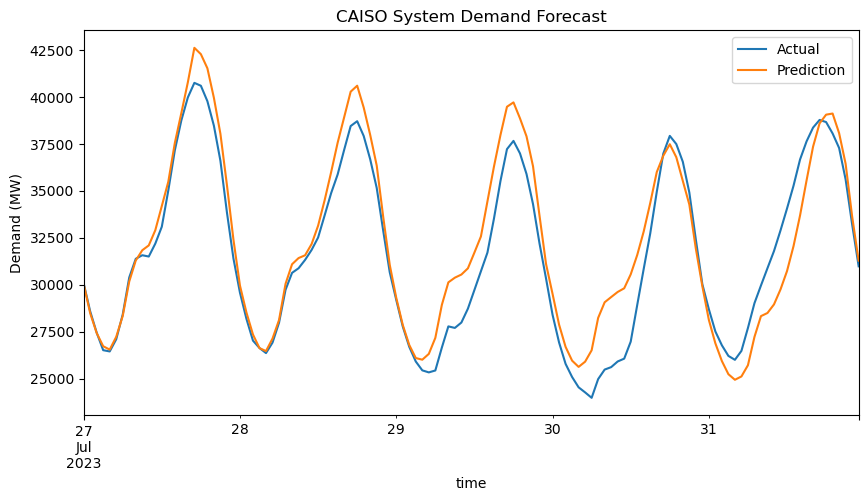

In [25]:
y_test.plot(figsize=(10, 5), ylabel="Demand (MW)", title="CAISO System Demand Forecast")
plt.show()